In [18]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from shutil import copyfile, move
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [3]:
print(os.listdir("/kaggle/input/skin-cancer-mnist-ham10000/"))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [4]:
data = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [5]:
data['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [6]:
!pip install barbar pytorch-ignite

In [7]:
pip install -q torch-summary


Note: you may need to restart the kernel to use updated packages.


In [8]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'/kaggle/working/skin_models/skinmodel50.pt') 
        self.val_loss_min = val_loss


In [10]:
def split_data(source, training,test,validation, split_size):    
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    test_length = int(len(files) - training_length)
    validation_length = int(training_length*0.1)
    training_length = int(training_length - validation_length)
    
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:training_length+validation_length]
    
    test_set = shuffled_set[training_length+validation_length:]
    
    for filename in training_set:
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = source + filename
        destination = validation + filename
        copyfile(this_file, destination)
        
    for filename in test_set:
        this_file = source + filename
        destination = test + filename
        copyfile(this_file, destination)

In [11]:
os.mkdir('/kaggle/working/skin_models/')

In [12]:
os.mkdir('/kaggle/working/orig/')
os.mkdir('/kaggle/working/orig/0.MEL/')
os.mkdir('/kaggle/working/orig/1.NV/')
os.mkdir('/kaggle/working/orig/2.BCC/')
os.mkdir('/kaggle/working/orig/3.AKIEC/')
os.mkdir('/kaggle/working/orig/4.BKL/')
os.mkdir('/kaggle/working/orig/5.DF/')
os.mkdir('/kaggle/working/orig/6.VASC/')

os.mkdir('/kaggle/working/skin/')
os.mkdir('/kaggle/working/skin/training/')
os.mkdir('/kaggle/working/skin/test/')
os.mkdir('/kaggle/working/skin/validation/')
os.mkdir('/kaggle/working/skin/training/0.MEL/')
os.mkdir('/kaggle/working/skin/training/1.NV/')
os.mkdir('/kaggle/working/skin/training/2.BCC/')
os.mkdir('/kaggle/working/skin/training/3.AKIEC/')
os.mkdir('/kaggle/working/skin/training/4.BKL/')
os.mkdir('/kaggle/working/skin/training/5.DF/')
os.mkdir('/kaggle/working/skin/training/6.VASC/')
os.mkdir('/kaggle/working/skin/validation/0.MEL/')
os.mkdir('/kaggle/working/skin/validation/1.NV/')
os.mkdir('/kaggle/working/skin/validation/2.BCC/')
os.mkdir('/kaggle/working/skin/validation/3.AKIEC/')
os.mkdir('/kaggle/working/skin/validation/4.BKL/')
os.mkdir('/kaggle/working/skin/validation/5.DF/')
os.mkdir('/kaggle/working/skin/validation/6.VASC/')

os.mkdir('/kaggle/working/skin/test/0.MEL/')
os.mkdir('/kaggle/working/skin/test/1.NV/')
os.mkdir('/kaggle/working/skin/test/2.BCC/')
os.mkdir('/kaggle/working/skin/test/3.AKIEC/')
os.mkdir('/kaggle/working/skin/test/4.BKL/')
os.mkdir('/kaggle/working/skin/test/5.DF/')
os.mkdir('/kaggle/working/skin/test/6.VASC/')

In [13]:
orig_all = '/kaggle/working/HAM10000/'
source_MEL = '/kaggle/working/orig/0.MEL/'
source_NV = '/kaggle/working/orig/1.NV/'
source_BCC = '/kaggle/working/orig/2.BCC/'
source_AKIEC = '/kaggle/working/orig/3.AKIEC/'
source_BKL = '/kaggle/working/orig/4.BKL/'
source_DF = '/kaggle/working/orig/5.DF/'
source_VASC = '/kaggle/working/orig/6.VASC/'

training_MEL = '/kaggle/working/skin/training/0.MEL/'
training_NV = '/kaggle/working/skin/training/1.NV/'
training_BCC = '/kaggle/working/skin/training/2.BCC/'
training_AKIEC = '/kaggle/working/skin/training/3.AKIEC/'
training_BKL = '/kaggle/working/skin/training/4.BKL/'
training_DF = '/kaggle/working/skin/training/5.DF/'
training_VASC = '/kaggle/working/skin/training/6.VASC/'
validation_MEL = '/kaggle/working/skin/validation/0.MEL/'
validation_NV = '/kaggle/working/skin/validation/1.NV/'
validation_BCC = '/kaggle/working/skin/validation/2.BCC/'
validation_AKIEC = '/kaggle/working/skin/validation/3.AKIEC/'
validation_BKL = '/kaggle/working/skin/validation/4.BKL/'
validation_DF = '/kaggle/working/skin/validation/5.DF/'
validation_VASC = '/kaggle/working/skin/validation/6.VASC/'

test_MEL = '/kaggle/working/skin/test/0.MEL/'
test_NV = '/kaggle/working/skin/test/1.NV/'
test_BCC = '/kaggle/working/skin/test/2.BCC/'
test_AKIEC = '/kaggle/working/skin/test/3.AKIEC/'
test_BKL = '/kaggle/working/skin/test/4.BKL/'
test_DF = '/kaggle/working/skin/test/5.DF/'
test_VASC = '/kaggle/working/skin/test/6.VASC/'

In [14]:
os.mkdir('/kaggle/working/HAM10000/')

In [19]:
part1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
part2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

for part in [part1,part2]:
    for img in tqdm(os.listdir(part)):
        copyfile(os.path.join(part, img), os.path.join('/kaggle/working/HAM10000/', img))    

100%|██████████| 5015/5015 [00:46<00:00, 108.52it/s]


In [20]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [21]:
data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [22]:
len(data)


10015

In [23]:
data = data.drop_duplicates(subset='lesion_id')

In [24]:
len(data)


7470

In [25]:
image_names = [x for x in data['image_id']]
diagnosis = [x for x in data['dx']]

In [26]:
print(len(image_names))
print(len(diagnosis))

7470
7470


In [27]:
print(image_names[0])
print(diagnosis[0])

ISIC_0027419
bkl


In [28]:
pd.unique(data['dx'])

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [29]:
for index, image in tqdm(enumerate(image_names)):
    image = image + '.jpg'
    if diagnosis[index] == 'mel':
        copyfile(os.path.join(orig_all, image), os.path.join(source_MEL, image))
    elif diagnosis[index] == 'nv':
        copyfile(os.path.join(orig_all, image), os.path.join(source_NV, image))
    elif diagnosis[index] == 'bcc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_BCC, image))
    elif diagnosis[index] == 'akiec': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_AKIEC, image))
    elif diagnosis[index] == 'bkl':
        copyfile(os.path.join(orig_all, image), os.path.join(source_BKL, image))
    elif diagnosis[index] == 'df':  
        copyfile(os.path.join(orig_all, image), os.path.join(source_DF, image))
    elif diagnosis[index] == 'vasc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_VASC, image))       

7470it [00:02, 3234.49it/s]


In [30]:
# Print amount of pictures for each class
print(len(os.listdir(source_MEL)))
print(len(os.listdir(source_NV)))
print(len(os.listdir(source_BCC)))
print(len(os.listdir(source_AKIEC)))
print(len(os.listdir(source_BKL)))
print(len(os.listdir(source_DF)))
print(len(os.listdir(source_VASC)))

614
5403
327
228
727
73
98


In [31]:
split_size = 0.8
split_data(source_MEL, training_MEL, test_MEL,validation_MEL, split_size)
split_data(source_NV, training_NV, test_NV,validation_NV, split_size)
split_data(source_BCC, training_BCC,test_BCC, validation_BCC, split_size)
split_data(source_AKIEC, training_AKIEC,test_AKIEC, validation_AKIEC, split_size)
split_data(source_BKL, training_BKL,test_BKL, validation_BKL, split_size)
split_data(source_DF, training_DF,test_DF, validation_DF, split_size)
split_data(source_VASC, training_VASC,test_VASC, validation_VASC, split_size)

In [32]:
# Print amount of pictures for each class after split, train/val.
print(len(os.listdir(training_MEL)))
print(len(os.listdir(test_MEL)))
print(len(os.listdir(validation_MEL)))
print(len(os.listdir(training_NV)))
print(len(os.listdir(test_NV)))
print(len(os.listdir(validation_NV)))
print(len(os.listdir(training_BCC)))
print(len(os.listdir(test_BCC)))
print(len(os.listdir(validation_BCC)))
print(len(os.listdir(training_AKIEC)))
print(len(os.listdir(test_AKIEC)))
print(len(os.listdir(validation_AKIEC)))
print(len(os.listdir(training_BKL)))
print(len(os.listdir(test_BKL)))
print(len(os.listdir(validation_BKL)))
print(len(os.listdir(training_DF)))
print(len(os.listdir(test_DF)))
print(len(os.listdir(validation_DF)))
print(len(os.listdir(training_VASC)))
print(len(os.listdir(test_VASC)))
print(len(os.listdir(validation_VASC)))

442
123
49
3890
1081
432
235
66
26
164
46
18
523
146
58
53
15
5
71
20
7


In [33]:
traindir = r'/kaggle/working/skin/training/'
valdir = r'/kaggle/working/skin/validation/'
test = r'/kaggle/working/skin/test/'

In [34]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(
    traindir, transform=train_transforms)

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

test_dataset = datasets.ImageFolder(
    valdir, transform=test_transforms)

In [35]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

In [36]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True,
    pin_memory=False, drop_last=False)

In [37]:
print(val_dataset.class_to_idx)
print(train_dataset.class_to_idx)

{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}
{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}


In [38]:
test_dataset.class_to_idx

{'0.MEL': 0,
 '1.NV': 1,
 '2.BCC': 2,
 '3.AKIEC': 3,
 '4.BKL': 4,
 '5.DF': 5,
 '6.VASC': 6}

In [41]:
device = 'cuda'

model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)

model.fc = nn.Linear(2048, 7).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

epochs = 5#300#5#500

writer = SummaryWriter(log_dir='/kaggle/working/skin_logs/', filename_suffix="skin50")

In [47]:
# Shows info about model
# summary(model, input_size=(3, 224, 224))

In [43]:
early_stopping = EarlyStopping(patience=50, verbose=True)

for epoch in range(epochs):
    train_loss = 0.00
    val_loss = 0.00
    train_accuracy = Accuracy()
    val_accuracy = Accuracy()
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, labels) in enumerate(Bar(train_loader)):
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
        train_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
    print(f"Train Accuracy: {train_accuracy.compute()}")
    train_loss /= len(train_loader)
    train_loss_formated = "{:.4f}".format(train_loss)

    # Validation loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            model.eval()           
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
    print(f"Val Accuracy: {val_accuracy.compute()}")
    val_loss /= len(val_loader)
    val_loss_formated = "{:.4f}".format(val_loss)
    print(f'Training Loss: {train_loss_formated}')
    print(f"Validation Loss: {val_loss_formated}")

    # TensorBoard writer 
    writer.add_scalar('Loss/train', train_loss, epoch+1)
    writer.add_scalar('Loss/val', val_loss, epoch+1)
    writer.add_scalar('Accuracy/train', train_accuracy.compute(), epoch+1)
    writer.add_scalar('Accuracy/val', val_accuracy.compute(), epoch+1)

    # Early Stopping
    early_stopping(val_loss, model)       
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
# model.load_state_dict(torch.load('/kaggle/working/skin_models/skinmodel50.pt'))   

Epoch 1
5378/5378: [===============================>] - ETA 1.9sss
Train Accuracy: 0.7288955001859427
Val Accuracy: 0.7411764705882353
Training Loss: 0.8262
Validation Loss: 0.9869
Monitored metric has improved (inf --> 0.986889).  Saving model ...
Epoch 2
5378/5378: [===============================>] - ETA 0.9ss
Train Accuracy: 0.761993306061733
Val Accuracy: 0.7529411764705882
Training Loss: 0.6639
Validation Loss: 0.7317
Monitored metric has improved (0.986889 --> 0.731680).  Saving model ...
Epoch 3
5378/5378: [===============================>] - ETA 0.9ss
Train Accuracy: 0.7727779843808107
Val Accuracy: 0.7647058823529411
Training Loss: 0.6350
Validation Loss: 0.6660
Monitored metric has improved (0.731680 --> 0.665963).  Saving model ...
Epoch 4
5378/5378: [===============================>] - ETA 0.9ss
Train Accuracy: 0.7815172926738565
Val Accuracy: 0.7647058823529411
Training Loss: 0.6061
Validation Loss: 0.6620
Monitored metric has improved (0.665963 --> 0.662013).  Saving mod

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         MEL       0.56      0.18      0.28        49
          NV       0.87      0.95      0.90       432
         BCC       0.31      0.54      0.39        26
       AKIEC       0.33      0.06      0.10        18
         BKL       0.36      0.36      0.36        58
          DF       0.00      0.00      0.00         5
        VASC       1.00      0.14      0.25         7

    accuracy                           0.76       595
   macro avg       0.49      0.32      0.33       595
weighted avg       0.75      0.76      0.74       595



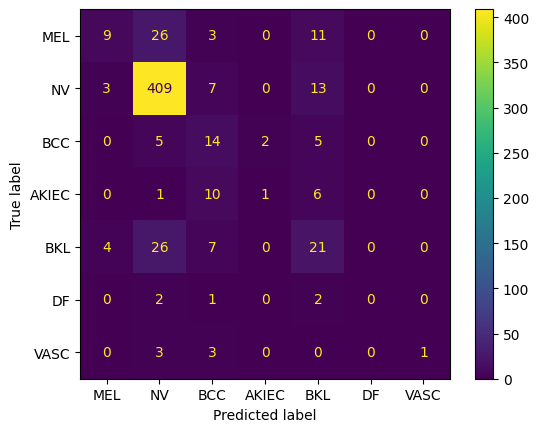

In [44]:
num_classes = 7

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        model.eval()
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
#         print(preds)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
#         predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
# predlistauc = predlistauc.numpy()

# Confusion matrix, classification report
conf_mat=confusion_matrix(lbllist, predlist)
target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")
print(classification_report(lbllist, predlist, target_names=target_names))
# lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
# every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
#                                           predlistauc, multi_class='ovr', average=None)
# for i, every in enumerate(target_names):
#     print(f'AUC of class {every} = {every_auc[i]}')

# Prediction

In [45]:
device = 'cuda'

model1 = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)

model1.fc = nn.Linear(2048, 7).to(device)

# load the last checkpoint with the best model
model1.load_state_dict(torch.load('/kaggle/working/skin_models/skinmodel50.pt'))   

<All keys matched successfully>

In [46]:
from torchvision import transforms
from PIL import Image

image_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg"

unseen_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert("RGB")
image = unseen_transforms(image)

# Reshape the image to add batch dimension
image = image.unsqueeze(0) 

with torch.no_grad():
    model1.eval()
    inputs = image.to(device)
    outputs = model1(inputs)
    _, preds = torch.max(outputs, 1)
    print(preds[0].item())

4
